## Feature Engineering

Now you have cleaned up the data and want to run some machine learning model to get some results. What’s the value of data science skills if you could simply run one-liner scikit-learn to make the prediction (think about Kaggle compeition)?

The questions may now become: how to makes a good prediction (model selection)?
1. **Choose the right feature (feature engineering/featurization)**
2. Choose the right algorithm (algorithm selection)
3. Choose the right parameter (parameter tuning)

![alt text](https://i1.wp.com/adataanalyst.com/wp-content/uploads/2016/08/Feature-Engineering.jpg "Feature Engineering")

Feature engineering: represent the data in the **_best way_** (pertinent structures/properties of the underlying information in the most effective way). 

> - "Coming up with features is difficult, time-consuming, requires expert knowledge. **"Applied machine learning" is basically feature engineering.**"
>  by Andrew Ng, _Machine Learning and AI via Brain simulations_
> - "At the end of the day, some machine learning projects succeed and some fail. What makes the difference? **Easily the most important factor is the features used.**" by Pedro Domingos, _A Few Useful Things to Know about Machine Learning_
> - "Good input features are essential for successful machine learning. **Feature engineering ≈ 90% of effort in industrial machine learning**” by Joshua Bengio, _Deep Learning for Big Data_     

Good feature engineering involves an elegant blend of domain knowledge, intuition, and basic mathematical abilities.

1. Hand-craft features from domain knowledge
2. Automated feature learning from data (learning of representation from shallow or deep learning)

Iterative feature engineering process:
1. Brainstorm the features (learn from partners, literatures, projects, etc.)
2. Devise features using manual **feature construction/transformation**, automatic **feature extraction** (e.g. from text, image, video), or the comination of the both
3. Choose features using different feature importance metrics to perform **feature selection** 
4. Check how features work with the model and improve the feature if needed

We will cover a few common examples of feature engineering tasks: features for representing categorical data and numerical data. We mainly rely on nice functions in `pandas`, `sklearn.preprocessing` and `sklearn.feature_selection`.

In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set(font_scale=1.3)
%matplotlib inline

### Encoding Categorical variables
Most implementations of ML algorithms require numerical data as input, and we have to prepare our data accordingly. Categorical variables, e.g. gender cannot be directly loaded into a ML algorithm without proper transformation. 

In [87]:
# Load example data
df = pd.DataFrame([
            ['green', 'M', 10.0, 'class1'], 
            ['red', 'L', 20.0, 'class2'], 
            ['blue', 'XL', 30.0, 'class1']])

df.columns = ['color', 'size', 'price', 'class label']
df


,color,size,price,class label
0,green,M,10.0,class1
1,red,L,20.0,class2
2,blue,XL,30.0,class1


Ordinal features need special attention: we have to make sure that the correct values are associated with the corresponding strings. Thus, we need to set-up an explicit mapping dictionary:

In [10]:
size_mapping = {
           'XL': 3,
           'L': 2,
           'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,class label
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


Using the *get_dummies* will create a new column for every unique string in a certain column (_aka_ dummification) This essentially transforms each categorical feature with m possible values into m binary features, with only one active.

*dummy\_na* option adds a column to indicate NaNs and *drop\_firs* gets k-1 dummies out of k categorical levels by removing the first level.

In [12]:
pd.get_dummies(df)

,price,color_blue,color_green,color_red,size_L,size_M,size_XL,class label_class1,class label_class2
0,10.1,0,1,0,0,1,0,1,0
1,13.5,0,0,1,1,0,0,0,1
2,15.3,1,0,0,0,0,1,1,0


Simiarly, converting categorical variables to features with scikit-learn is to transform lists of feature-value mappings to vectors with *DictVectorizer*. This transformer turns lists of mappings (dict-like objects) of feature names to feature values into Numpy/Scipy arrays for use with scikit-learn estimators.

In [73]:
from sklearn.feature_extraction import DictVectorizer

dvec = DictVectorizer(sparse=False)

X = dvec.fit_transform(df.transpose().to_dict().values())
print X

[[  1.    0.    1.   10.1   0.    1.    0. ]
 [  0.    1.    2.   13.5   1.    0.    0. ]
 [  1.    0.    0.   15.3   0.    0.    1. ]]


Once converting numpy array to data.frame, we essentially get the same results as we use *get_dummies*.

In [63]:
pd.DataFrame(X, columns=dvec.get_feature_names())

,class label=class1,class label=class2,color=blue,color=green,color=red,price,size=L,size=M,size=XL
0,1.0,0.0,0.0,1.0,0.0,10.1,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,13.5,1.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,15.3,0.0,0.0,1.0


Note that this transformer will only do a *one-of-K* or *one-hot encoding*, when feature values are of type string. If categorical features are represented as numeric values such as int, the DictVectorizer can be followed by OneHotEncoder to complete binary one-hot encoding.

In [81]:
from sklearn.preprocessing import LabelEncoder

color_le = LabelEncoder()
df['color'] = color_le.fit_transform(df['color'])

df

,color,size,price,class label
0,1,M,10.1,class1
1,2,L,13.5,class2
2,0,XL,15.3,class1


Then _OneHotEncoder_ can encode the numeric value as if it were categorical values. 

In [82]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)

X = ohe.fit_transform(df[['color']].values)
print X
#pd.DataFrame(X, columns=dvec.get_feature_names())

[[ 0.  1.  0.]
 [ 0.  0.  1.]
 [ 1.  0.  0.]]


### Encoding Numerical Values
**sklearn.preprocessing** also provides numerous transformation functions to encode numerical values into features:
1. Standardization
2. Normalization
3. Binarization
4. Imputation of missing values

**Standardization** handles data measured at different units of measurement before applying ML algorithims. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected (e.g. graident descent often used in logistic regression, SVMs, perceptrons, neural networks may update weights of certain features faster than others).

**Z-score normalization** transform the data to center it by removing the mean value of each feature, then scale it by dividing non-constant features by their standard deviation: 
\begin{equation} z = \frac{x - \mu}{\sigma}\end{equation} 

In [103]:
from sklearn.preprocessing import scale

df['price'] = scale(df['price'])
print df
print "The mean of price after standardizationis %f and std is %f" \
% (df['price'].mean(axis=0), df['price'].std(axis=0))

   color size     price class label
0  green    M -1.224745      class1
1    red    L  0.000000      class2
2   blue   XL  1.224745      class1
The mean of price after standardizationis 0.000000 and std is 1.224745


_StandardScaler_ can be used to standardize features on a training set so as to be able to later reapply the same transformation on the testing set. 

In [164]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()

X = iris.data
y = iris.target

print(pd.DataFrame(X).head())

standardized_X = StandardScaler().fit_transform(X)

print(pd.DataFrame(standardized_X).head())

     0    1    2    3
0  5.1  3.5  1.4  0.2
1  4.9  3.0  1.4  0.2
2  4.7  3.2  1.3  0.2
3  4.6  3.1  1.5  0.2
4  5.0  3.6  1.4  0.2
          0         1         2         3
0 -0.900681  1.032057 -1.341272 -1.312977
1 -1.143017 -0.124958 -1.341272 -1.312977
2 -1.385353  0.337848 -1.398138 -1.312977
3 -1.506521  0.106445 -1.284407 -1.312977
4 -1.021849  1.263460 -1.341272 -1.312977


An alternative approach to Z-score normalization (or standardization) is the so-called **Min-Max scaling** to scale features to lie between a given minimum and maximum value, often between zero and one: 
\begin{equation} X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} \end{equation}

The motivation to use this scaling include robustness to very small standard deviations of features to suppress the effect of outlier and preserving zero entries in sparse data.

In [126]:
from sklearn.preprocessing import MinMaxScaler

X_minmax = MinMaxScaler().fit_transform(X)

print(pd.DataFrame(X_minmax).head())

print X_minmax.std(axis=0)

          0         1         2         3
0  0.222222  0.625000  0.067797  0.041667
1  0.166667  0.416667  0.067797  0.041667
2  0.111111  0.500000  0.050847  0.041667
3  0.083333  0.458333  0.084746  0.041667
4  0.194444  0.666667  0.067797  0.041667
[ 0.22925036  0.18006108  0.29805579  0.31692192]


"Standardization or Min-Max scaling?" The answer depends on the application. For example, in clustering analyses, standardization may be especially crucial in order to compare similarities between features based on certain distance measures. On the other hand, typical neural network algorithm require data that on a 0-1 scale that Min-Max scaling would be helpful.

**Normalization**  is the process of **scaling individual samples to have unit norm.** Scaling inputs to unit norms is a common operation for text classification or clustering.

In [179]:
from sklearn.preprocessing import Normalizer

X_norm = Normalizer(norm='l2').fit_transform(X) 
X_norm2 = Normalizer(norm='l2').fit_transform(X_minmax) 
print(pd.DataFrame(X_norm).head())

          0         1         2         3
0  0.803773  0.551609  0.220644  0.031521
1  0.828133  0.507020  0.236609  0.033801
2  0.805333  0.548312  0.222752  0.034269
3  0.800030  0.539151  0.260879  0.034784
4  0.790965  0.569495  0.221470  0.031639


**Binarization** is the process of **thresholding numerical features to get boolean values.** Similar to encoding categorical feature, binazation set feature values to 0 or 1 according to a threshold, i.e., Values greater than the threshold map to 1, while values less than or equal to the threshold map to 0. 
Binarization is a common operation on count data when only considering the presence or absence of a feature rather than a quantified number of occurrences for instance.


In [136]:
from sklearn.preprocessing import Binarizer

X_bin = Binarizer(threshold = 1).fit_transform(X) 

print(pd.DataFrame(X_bin).head())

     0    1    2    3
0  1.0  1.0  1.0  0.0
1  1.0  1.0  1.0  0.0
2  1.0  1.0  1.0  0.0
3  1.0  1.0  1.0  0.0
4  1.0  1.0  1.0  0.0


**Imputation of missing value** deal with the missing value issue (often as NaN, empty value, etc.) As ML algorithms implemented in scikit-learn assume that all values in an array are numerical, and that all have and hold meaning, using incomplete datasets to discard entire rows and/or columns containing missing values comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data.

The _Imputer_ class provides basic strategies for imputing missing values, either using the mean, the median or the most frequent value of the row or column in which the missing values are located. 

In [145]:
from sklearn.preprocessing import Imputer
# If axis=0, then impute along columns. The imputation strategy include mean, median and most_frequent
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
print(imp.transform([[np.nan, 2], [6, np.nan], [7, 6]]))

[[ 4.          2.        ]
 [ 6.          3.66666667]
 [ 7.          6.        ]]


**Polynomial features** adds complexity to the model by considering nonlinear features of the input data. For example, polynomial feature generates high-order and interaction terms from $(X_1, X_2)$ to $(1, X_1, X_2, X_1^2, X_1X_2, X_2^2)$

In [150]:
from sklearn.preprocessing import PolynomialFeatures

X_poly = PolynomialFeatures(2).fit_transform(X[:, :2] )
print(pd.DataFrame(X_poly).head())

     0    1    2      3      4      5
0  1.0  5.1  3.5  26.01  17.85  12.25
1  1.0  4.9  3.0  24.01  14.70   9.00
2  1.0  4.7  3.2  22.09  15.04  10.24
3  1.0  4.6  3.1  21.16  14.26   9.61
4  1.0  5.0  3.6  25.00  18.00  12.96


### Feature Selction

**Feature selection**, is the process of selecting a subset of relevant features from a high-dimensional feature space for use in model construction (after _feature explosion_ from e.g. feature extraction and transformations). Generally, it can enhance generalization by reducing overfitting, simplify the model to be trained and interpreted. 

Simple feature selection such as univariate feature selection works by selecting the best features based on univariate statistical tests. 

<Container object of 4 artists>

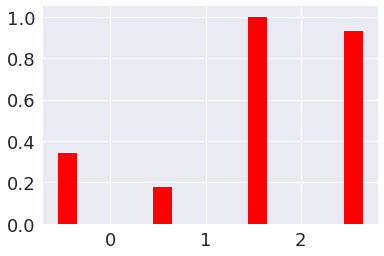

In [157]:
from sklearn.feature_selection import  SelectPercentile, f_classif

plt.figure(1)
plt.clf()

X_indices = np.arange(X.shape[-1])

#Univariate feature selection with F-test for feature scoring
selector = SelectPercentile(f_classif, percentile=10)
selector.fit(X, y)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='red')

**Recursive feature elimination** selects features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and weights are assigned to each one of them. Then, features whose absolute weights are the smallest are pruned from the current set features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [159]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

svm = LinearSVC()
# create the RFE model for the svm classifier 
# and select attributes
rfe = RFE(svm, 3)
rfe = rfe.fit(X, y)
# print summaries for the selection of attributes
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True]
[2 1 1 1]


**Tree-based feature selection** can be used to compute feature importances, which in turn can be used to discard irrelevant features

In [161]:
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=50,
                              random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


Feature ranking:
1. feature 3 (0.436920)
2. feature 2 (0.420234)
3. feature 0 (0.078254)
4. feature 1 (0.064592)


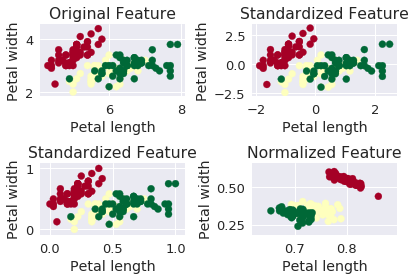

In [210]:
def visuvalize_petal_data(X_data, desc):
    
    plt.scatter(X_data[:, 0], X_data[:, 1], c=y, cmap=plt.cm.RdYlGn)
    plt.xlabel('Petal length')
    plt.ylabel('Petal width')
    plt.title(desc)
    #plt.show()


plt.subplot(2, 2, 1)  
visuvalize_petal_data(X, 'Original Feature')
plt.subplot(2, 2, 2)  
visuvalize_petal_data(standardized_X, 'Standardized Feature')
plt.subplot(2, 2, 3)  
visuvalize_petal_data(X_minmax, 'Standardized Feature')
plt.subplot(2, 2, 4)
visuvalize_petal_data(X_norm, 'Normalized Feature')

plt.tight_layout()
plt.show()